In [1]:
import requests
import lxml.html as lh
import pandas as pd
import re

In [2]:
#This code is inspired in https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
def parse_url(url, date):
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)

    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)

    #Parse data that are stored between <tr>..</tr> of HTML
    #tr_elements = doc.xpath('//tr')
    tr_elements = doc.xpath('/html/body/div[1]/div[4]/div[1]/div/div[3]/table/tbody/tr')
        
    
    #Create empty list
    col=[]
    i=0#For each row, store each first element (header) and an empty list
    for t in tr_elements[0]:
        i+=1
        name=t.text_content().strip()
        #print ("column:", i, name)
        col.append((name,[]))
        
    #Append the date column   
    col.append(("Fecha", []))
        
    #Since out first row is the header, data is stored on the second row onwards
    for j in range(1,len(tr_elements)):
        #print ("row:", j)
        
        #T is our j'th row
        T=tr_elements[j]
        #print ("row:", T)

        #If row is not of size 10, the //tr data is not from our table 
        if len(T)!=2:
            break

        #i is the index of our column
        i=0

        #Iterate through each element of the row
        for t in T.iterchildren():
            #print("i:", i, "j:", j, "cell:", t)
            data=t.text_content().strip() 
            #print("i:", i, "j:", j, "data:", data)
            #Check if row is empty
            if i>0:
            #Convert any numerical value to integers
                try:
                    data=int(data)                    
                except:
                    pass
            #Append the data to the empty list of the i'th column
            #print (data)
            col[i][1].append(data)
            #Increment i for the next column
            i+=1    
            
        #Append the date column   
        col[i][1].append(date)
            
    #print("col:", col)        
    
    Dict={title:column for (title,column) in col}    
    df=pd.DataFrame(Dict)
    #df.head()
    
    return df


In [3]:
#!pip install PyPDF2
def parse_pdf_url(url, date):
    import PyPDF2

    response = requests.get(url)
    my_raw_data = response.content

    with open("my_pdf.pdf", 'wb') as my_data:
        my_data.write(my_raw_data)

    page_content = ""
        
    read_pdf = PyPDF2.PdfFileReader("my_pdf.pdf")
    number_of_pages = read_pdf.getNumPages()
    #page = read_pdf.getPage(0)
    #page_content = page.extractText()
    for page_number in range(number_of_pages):   # use xrange in Py2
            page = read_pdf.getPage(page_number)
            page_content = page_content + page.extractText()
            
    page_content = clean_pdf_content(page_content)        
            
    page_content_split = page_content.split('\n \n')
    type(page_content_split)
        
    page_content_split_filtered = list(filter(lambda x: "nosticados" not in x and "notificados" not in x and "Zona Básica" not in x and x != "Casos" and x != " " and x != "" and x != " \n" and not "/2020" in x, page_content_split))
    #print(page_content_split_filtered)

    elements = int((len(page_content_split_filtered))/2)
    #print(elements)
    type(elements)

    import  numpy as np
    reshaped_array = np.reshape(np.array(page_content_split_filtered), (elements, 2))

    a_dataframe = pd.DataFrame(reshaped_array, columns=["Zona Básica", "Casos"])
    a_dataframe = a_dataframe.astype({'Casos': 'int32'})

    a_dataframe = a_dataframe.assign(Fecha=[date]*elements)
    
    return a_dataframe

def clean_pdf_content(page_content):    
        
    page_content = page_content.replace("1\n \n \nCasos\n \nnotificados", "Casos notificados") 
            
    page_content = page_content.replace("TORRERO\n \nLA PAZ", "TORRERO LA PAZ")
    page_content = page_content.replace("AVENIDA \nCATALUÑA", "AVENIDA CATALUÑA")
    page_content = page_content.replace("BIESCAS\n-\nVALLE DE TENA", "BIESCAS-VALLE DE TENA ")
    page_content = page_content.replace("SANTA \nEULALIA DEL CAMPO", "SANTA EULALIA DEL CAMPO")
    page_content = page_content.replace("VALDESPARTERA\n-\nMONTECANAL", "VALDESPARTERA-MONTECANAL")
    page_content = page_content.replace("SAGASTA\n-\nRUISEÑORES", "SAGASTA-RUISEÑORES")
    page_content = page_content.replace("HUESCA CAPITAL -1 \n(PERPETUO SOCORRO", "HUESCA CAPITAL Nº 1 (PERPETUO SOCORRO)")
    page_content = page_content.replace("HUESCA CAPITAL Nº 1 \n(PERPETUO SOCORRO", "HUESCA CAPITAL Nº 1 (PERPETUO SOCORRO)")
    page_content = page_content.replace("HUESCA CAPITAL Nº 2 (SANTO \nGRIAL)", "HUESCA CAPITAL Nº 2 (SANTO GRIAL)")
    page_content = page_content.replace("MADRE \nVEDRUNA\n-\nMIRAFLORES", "MADRE VEDRUNA-MIRAFLORES")
    page_content = page_content.replace("MADRE VEDRUNA\n-\nMIRAFLORES", "MADRE VEDRUNA-MIRAFLORES") 
    page_content = page_content.replace("FERNANDO EL\n \nCATOLICO", "FERNANDO EL CATOLICO")    
    page_content = page_content.replace("SAN JOSE\n \nNORTE", "SAN JOSE NORTE")
    
    page_content = page_content.replace("\n-\n \n", "-")
    page_content = page_content.replace("Nº\n \n", "-")
        
    page_content = re.sub(r'(\d+)\n \n\d+', r'\1', page_content)
    
    #print(page_content)
        
    return page_content

In [4]:
#Scrap the HTML as data frames
frames = [parse_url("http://www.aragonhoy.net/index.php/mod.noticias/mem.detalle/relmenu.9/id.263522", "2020-07-21"), 
          parse_url("http://www.aragonhoy.net/index.php/mod.noticias/mem.detalle/relmenu.9/id.263587", "2020-07-22"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_zonas_de_salud_240720_b207d97a%232E%23pdf", "2020-07-23"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_diagnosticados_el_24_21d693c5%232E%23pdf", "2020-07-24"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_diagnosticados_a_25_f6c24e2b%232E%23pdf", "2020-07-25"),              
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_27_f174cec5%232E%23pdf", "2020-07-26"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_28_502913f8%232E%23pdf", "2020-07-27"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_el_29_8534c52d%232E%23pdf", "2020-07-28"),
          parse_pdf_url("http://www.aragonhoy.net/index.php/mod.documentos/mem.descargar/fichero.documentos_Casos_notificados_a_30_11f0e64d%232E%23pdf", "2020-07-29")]

#Concatenate the data frames
result = pd.concat(frames)

result.head()

#Pivot the table
table = pd.pivot_table(result, values='Casos', index=['Zona Básica'],
                    columns=['Fecha'], fill_value=0)

#print(table)
    

In [5]:
#Delete the TOTAL row, because we do not have total every day
table = table[table.index != "TOTAL"]
#Create the TOTAL row again
table = table.append(table.sum().rename('TOTAL'))

#Create the TOTAL column
total_column = table["2020-07-21"] + table["2020-07-22"] + table["2020-07-23"] + table["2020-07-24"] + table["2020-07-25"] + table["2020-07-26"] + table["2020-07-27"] + table["2020-07-28"]
table["TOTAL"] = total_column

#10 health districts with most cases
top_10 = table[table.index != "TOTAL"].sort_values(by=['TOTAL'], ascending=False).head(10)


In [6]:
#transpose the top 10
top_10_t = top_10.transpose()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11, 4)})

top_10_t[top_10_t.index != "TOTAL"].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

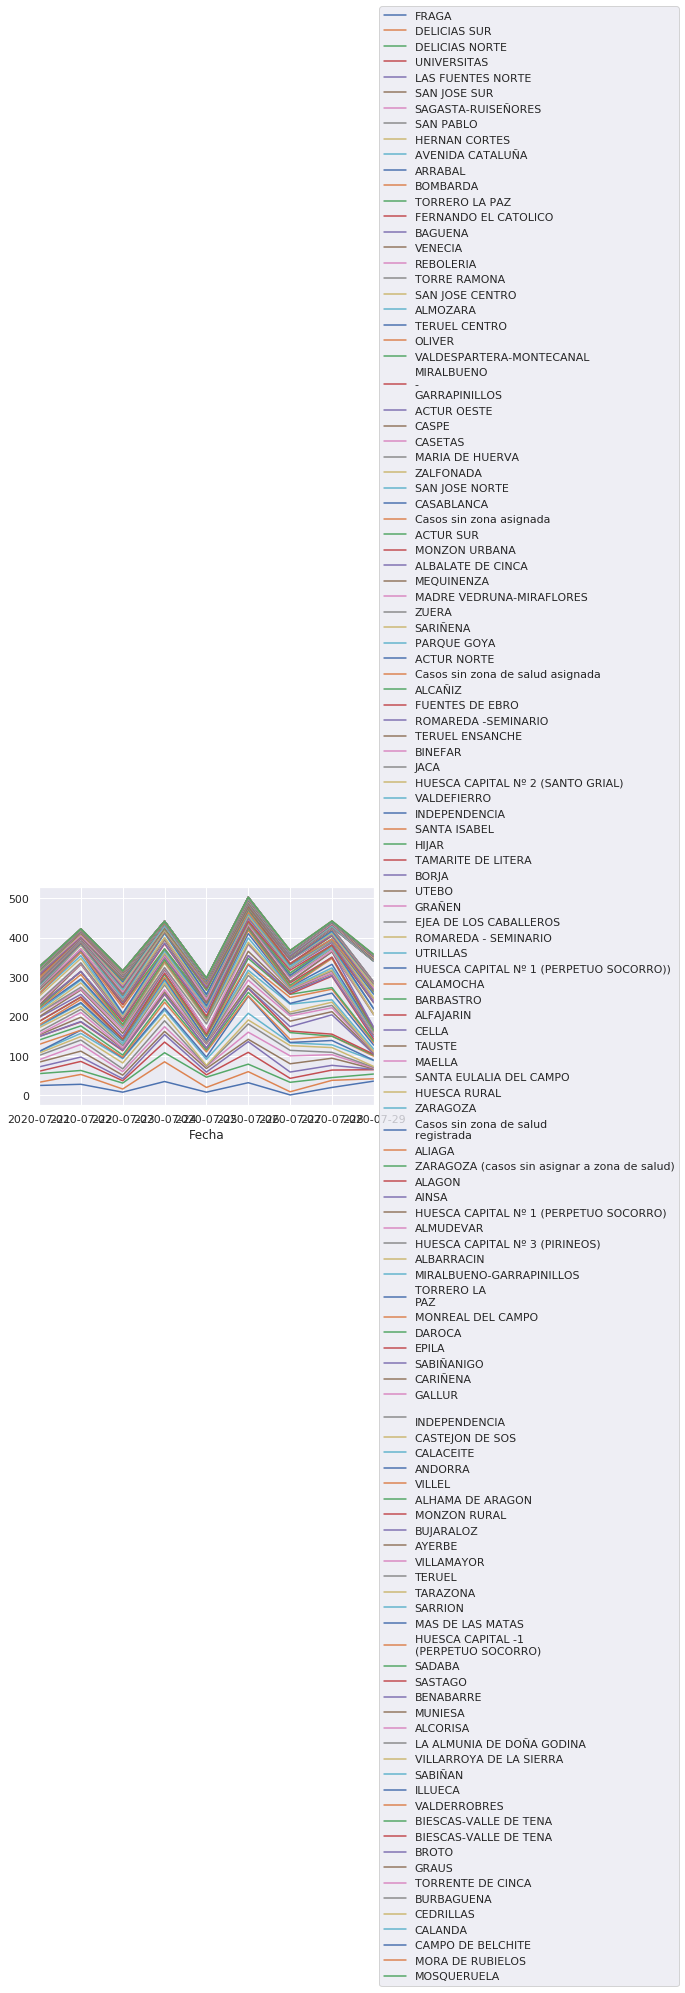

In [8]:
table_no_total = table[table.index != "TOTAL"].sort_values(by=['TOTAL'], ascending=False)
table_no_total_t =  table_no_total.transpose()

table_no_total_t[table_no_total_t.index != "TOTAL"].plot(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))